In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_validate

### Считываем данные в один датафрейм

In [2]:
messages_dir = './messages/part'
messages = []

for i in range(1, 11):
    messages_part = []
    for message_filename in os.listdir(messages_dir + str(i)):
        message_file = open(messages_dir + str(i) + "/" + message_filename, "r")
        subject = message_file.readline()[9:-1]
        message_file.readline()
        text = message_file.readline()[:-1]
        is_spam = 1 if 'spmsg' in message_filename else 0

        messages.append([subject, text, is_spam])

In [3]:
messages = pd.DataFrame(messages, columns=['subject', 'text', 'spam'])
X = messages['subject'] + ' ' + messages['text']
y = messages['spam']

In [4]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(X).toarray()

### Реализация наивного Байесовского классификатора

In [5]:
class NaiveBayesClassifier(BaseEstimator):
    def __init__(self, smooth=1.0, lambdas=None):
        self.smooth = smooth
        self.lambdas = lambdas

    def fit(self, X, y):
        self.total_counts = np.sum(X, axis=0)
        self.labels = np.unique(y)

        self.word_probas = np.zeros((self.labels.shape[0], self.total_counts.shape[0]))
        self.label_probas = np.zeros(self.labels.shape[0])

        for label in self.labels:
            self.word_probas[label] = (np.sum(X[y == label], axis=0) + self.smooth) / (
                    self.smooth * X.shape[1] + np.sum(X[y == label]))
            self.label_probas[label] = float(y[y == label].shape[0]) / y.shape[0]

    def _log_proba(self, x, label):
        return np.log(self.labels_weights[label] * self.label_probas[label]) + np.sum(
            np.log(self.word_probas[label][x != 0]))

    def predict_log_proba(self, X):
        label_probas = np.zeros((X.shape[0], self.labels.shape[0]))
        self.labels_weights = np.ones((self.labels.shape[0],)) if self.lambdas is None else self.lambdas

        for i in np.arange(0, X.shape[0]):
            for label in self.labels:
                label_probas[i][label] = self._log_proba(X[i], label)

        return label_probas

    def predict(self, X):
        return np.argmax(self.predict_log_proba(X), axis=1)

    def predict_proba(self, X):
        label_log_probas = self.predict_log_proba(X)

        for i in np.arange(0, X.shape[0]):
            label_log_probas[i] = [
                1 / (1 + np.exp(label_log_probas[i][1] - label_log_probas[i][0])),
                1 / (1 + np.exp(label_log_probas[i][0] - label_log_probas[i][1]))
            ]

        return label_log_probas


### Оценка модели

In [6]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score)
}
score = cross_validate(NaiveBayesClassifier(), X, y, cv=10, scoring=scoring)

print('accuracy:', np.mean(score['test_accuracy']))
print('f1_score:', np.mean(score['test_f1_score']))

accuracy: 0.9678899082568808
f1_score: 0.964164842418001


In [7]:
def plot_roc_curve(y, y_proba):
    fpr, tpr, thresholds = roc_curve(y, y_proba[:, 1])
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

c:\users\oleg naumov\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in exp
c:\users\oleg naumov\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp


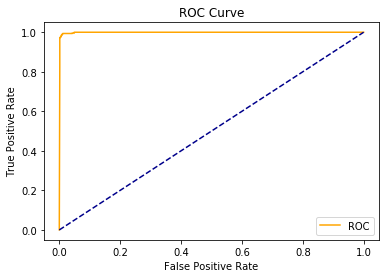

In [8]:
spam_classifier = NaiveBayesClassifier()
spam_classifier.fit(X, y)
y_pred_proba = spam_classifier.predict_proba(X)

plot_roc_curve(y, y_pred_proba)

### Поиск лямбды, при которой ни одно реальное сообщение не классифицируется как спам

In [9]:
def class_accuracy(y, y_pred, label):
    y_labels = y[y == label]
    y_pred_labels = y_pred[y == label]
    return float(np.sum(y_labels == y_pred_labels)) / y_labels.shape[0]

In [10]:
f1_scores = []
legit_accuracy = []
spam_accuracy = []
power = 0
fp = -1
while fp != 0:
    spam_classifier = NaiveBayesClassifier(lambdas=[10 ** power, 1])
    spam_classifier.fit(X, y)

    y_pred = spam_classifier.predict(X)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    print("%2d: TN = %3d, FP = %2d, FN = %2d, TP = %3d" % (power, tn, fp, fn, tp))
    f1_scores.append(f1_score(y, y_pred))
    legit_accuracy.append(class_accuracy(y, y_pred, 0))
    spam_accuracy.append(class_accuracy(y, y_pred, 1))
    power += 1

 0: TN = 596, FP = 14, FN =  3, TP = 477
 1: TN = 599, FP = 11, FN =  3, TP = 477
 2: TN = 601, FP =  9, FN =  3, TP = 477
 3: TN = 604, FP =  6, FN =  4, TP = 476
 4: TN = 604, FP =  6, FN =  5, TP = 475
 5: TN = 605, FP =  5, FN =  6, TP = 474
 6: TN = 607, FP =  3, FN = 11, TP = 469
 7: TN = 609, FP =  1, FN = 14, TP = 466
 8: TN = 609, FP =  1, FN = 19, TP = 461
 9: TN = 609, FP =  1, FN = 34, TP = 446
10: TN = 609, FP =  1, FN = 41, TP = 439
11: TN = 609, FP =  1, FN = 52, TP = 428
12: TN = 609, FP =  1, FN = 55, TP = 425
13: TN = 609, FP =  1, FN = 57, TP = 423
14: TN = 609, FP =  1, FN = 63, TP = 417
15: TN = 609, FP =  1, FN = 73, TP = 407
16: TN = 609, FP =  1, FN = 80, TP = 400
17: TN = 609, FP =  1, FN = 88, TP = 392
18: TN = 609, FP =  1, FN = 99, TP = 381
19: TN = 610, FP =  0, FN = 107, TP = 373


Зависимость f1_score от значения lambda.

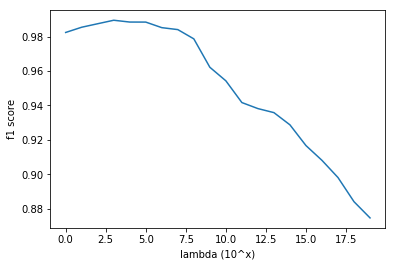

In [11]:
plt.plot(range(0, power), f1_scores)
plt.xlabel('lambda (10^x)')
plt.ylabel('f1 score')
plt.show()

Точность предксказания по каждому классу в зависмости от значения lambda.

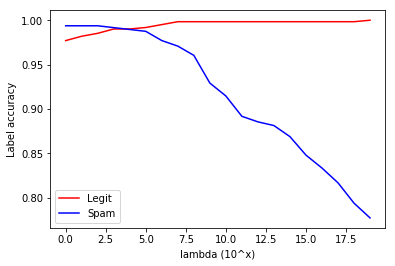

In [12]:
plt.plot(range(0, power), legit_accuracy, 'r-', range(0, power), spam_accuracy, 'b-')
plt.xlabel('lambda (10^x)')
plt.ylabel('Label accuracy')
plt.legend(['Legit', 'Spam'])
plt.show()